# Disk-Graph PRM - Demo
This notebook demonstrates how to use the DGPRM planner in a static environment. 

In [1]:
from dgprm import *
from geometry_utilities.occ_env import *

plt.rcParams["figure.figsize"] = (12,12)
plt.rcParams["font.size"] = 22.0

---
## Initialization

Let's start by setting up the environment using the `OccupancyEnv` utility class, which is simply a wrapper for a 2D occupancy map. The occupancy map is initialized using a grayscale image where each pixel represents the occupancy value. A set of test environments is provided (as .png images) in the `test_environments` directory : 
- 2rooms_corridor
- carte_entree
- env_4rooms
- env_boxes
- env_bugtrap
- env_div
- env_fhw
- env_freiburg_building
- env_intellab
- env_narrow
- env_narrow_triple

In [2]:
# Set up the environment
ENV_PATH = "test_environments/"
ENV_NAME = "env_narrow"
env = OccupancyEnv()
env.setFromImg(ENV_PATH + ENV_NAME + ".png")
#env.display()


We now initialize the planner using a hyperparameters dictionary which sets all the relevant values :
- `robot_rad` : robot radius, defining the minimal free-space bubble radius
- `max_rad` : maximal radius of the free-space bubbles - this parameter is not very relevant for the environment considered here, but can be helpful to limit the expansion of the graph in unknown space when planning in partially unknown environments
- `sampling_cutoff_dist` : *(denoted in the paper as $d_{samp}$)* : distance used as the scale parameter of the exponential distribution for the biased sampling step 
- `n_knn` : number of neighbors checked for validity during the expansion step
- `closing_rad_mult` : *(denoted in the paper as $\rho_{close}$)* : closing-radius multiplier used during the expansion step
- `opening_rad_mult` : *(denoted in the paper as $\rho_{open}$)* : opening-radius multiplier used during the expansion step

In [3]:
# Set up the DGPRM planner
planner_parameters = {
    "robot_rad" : 2,
    "max_rad" : 1000,
    "sampling_cutoff_dist" : 50,
    "n_knn" : 5,
    "closing_rad_mult" : 1.05,
    "opening_rad_mult" : 4
}

planner = DiskGraphPRM()
planner.initFromHyperparamsDict(planner_parameters)

The planner is now initialized but the graph is still empty. To conclude the initialization, we simply add an initial node at a given configuration, for which we can set the bubble radius to 0. The correct bubble radius is then computed by calling `recomputeNodesRadii`.

In [4]:
# Initialization step
init_pos = [50,50] 
planner.addBubble(BubbleNode(init_pos, 0))
planner.recomputeNodesRadii(env)

([], [0])

In [5]:
planner.expandPlanPath(np.array([50,50]), np.array([350,350]), env, 50, max_samples=1000)

Sampling 50 new samples - Init. vertices in graph : 1
Finished processing samples - 10/50 added
Sampling 50 new samples - Init. vertices in graph : 11
Finished processing samples - 33/50 added
Sampling 50 new samples - Init. vertices in graph : 44
Finished processing samples - 5/50 added
Sampling 50 new samples - Init. vertices in graph : 49
Finished processing samples - 6/50 added
Sampling 50 new samples - Init. vertices in graph : 55
Finished processing samples - 1/50 added
Sampling 50 new samples - Init. vertices in graph : 56
Finished processing samples - 46/50 added
No path exists between start 0 and goal 92 in the current graph


(None, None)

---
## Sampling and expansion
We first demonstrate how to sample a new set of samples based on the current state of the disk-graph and expand towards the obtained samples set; we also demonstrate usage of a higher-level method to do the complete sampling and expansion step. 



### Sampling
The sampling step can be visualized by calling the `sampleFromExponDistrib` method, passing in `show=True` :

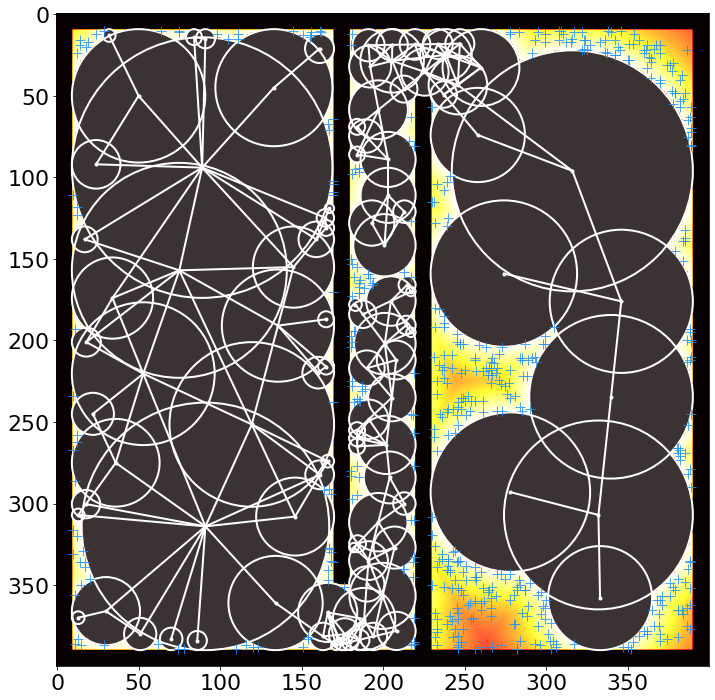

In [6]:
displayBubbles(planner.graph, color=[1,1,1,0], alpha=0, edges_color='white')
samples = planner.sampleFromExponDistrib(env, 500, planner.sampling_cutoff_dist, show=True)

### Expansion
To expand towards the new samples, we simply call the `expand` method and pass the samples obtained at the previous step as a parameter :

In [7]:
max_iter = 10000
planner.expand(env, samples, max_iter, show=False, save='./expansion_figures/step_expand_n_nodes')
#planner.expand(env, samples, max_iter, show=True, save=None)

([], True)

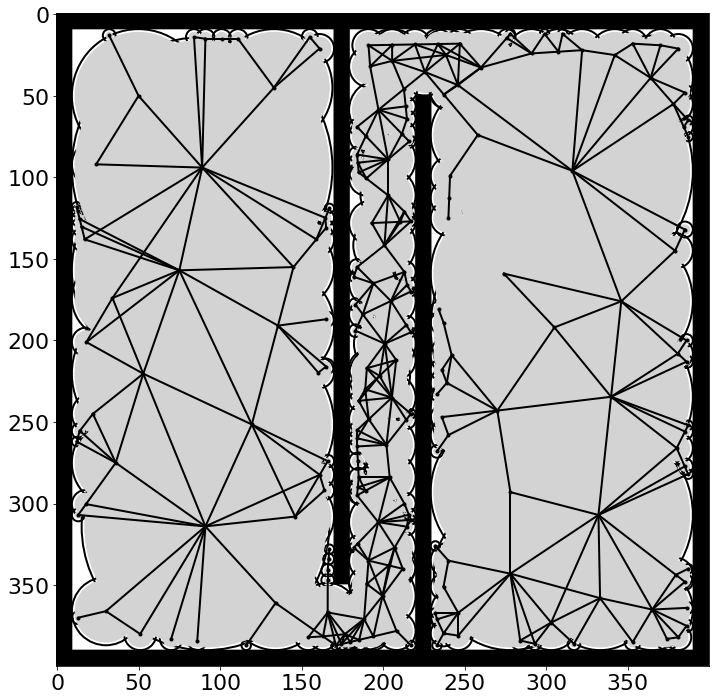

In [8]:
env.display()
displayBubbles(planner.graph, color='lightgrey')

### Sampling + expansion
To simplify the expansion step, we also provide the `expandNSamples` method which samples $N$ new samples from the probability map corresponding to the current state of the planner and directly tries to expand towards this samples set :

In [9]:
# Sampling and expansion step
planner.expandNSamples(env, 10)

Sampling 10 new samples - Init. vertices in graph : 212
Finished processing samples - 4/10 added


4

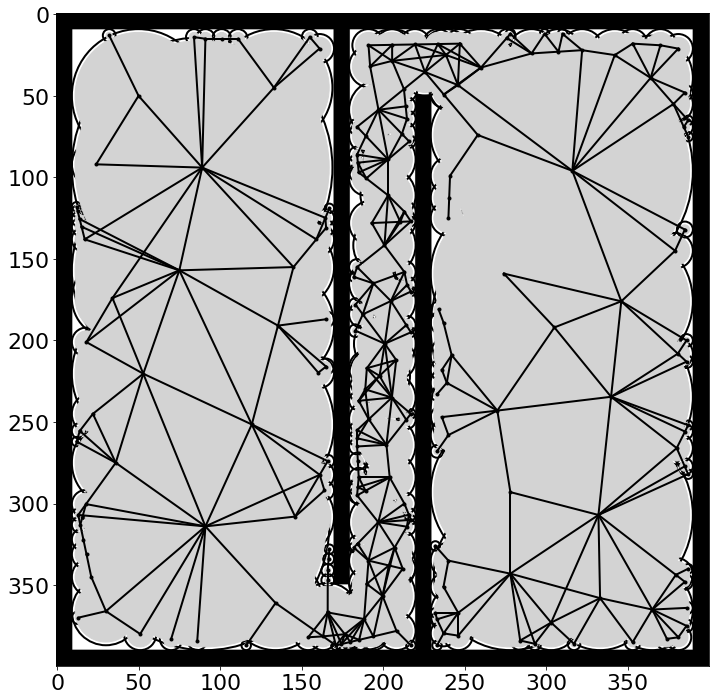

In [10]:
env.display()
displayBubbles(planner.graph, color='lightgrey')

In [11]:
save_path = "./figures/sampling_hyperparam_influence.png"
save = False
'''
plt.figure(figsize=(20,15))
for i,rho in enumerate([1,1.1,1.5]):
    for j,d in enumerate([10,50,100,500]):
        plt.subplot(3,4,(j+i*4)+1)
        displayBubbles(planner.graph, color=[1,1,1,0], alpha=0, lw=1, edges_color='white')
        samples = planner.sampleFromExponDistrib(env, 200, d, radInflationMult=rho, show=True)
'''
if save:
    plt.savefig(save_path, facecolor=[1,1,1,1], pad_inches = 0.05)

---
## Path planning
We now obtained a roadmap which covers at least partially the environment; paths can be planned between any two configurations contained inside the disk-graph. Path existence between such configurations is guaranteed by the connectivity of the roadmap, itself guaranteed by construction.

In [12]:
# Planning step
start_pos = np.array([50,50])
goal_pos = np.array([350,350])
path, path_radii = planner.planPath(start_pos, goal_pos)

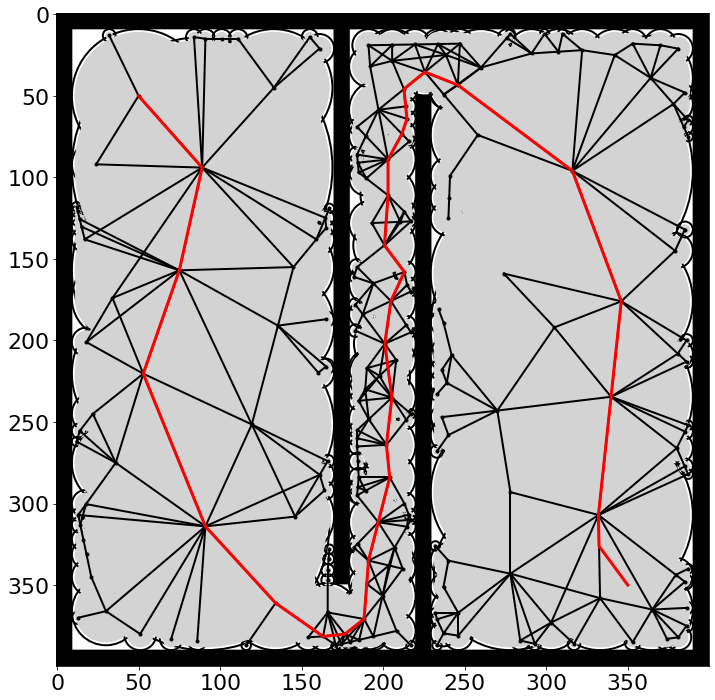

In [13]:
env.display()
displayBubbles(planner.graph, color='lightgrey')
plt.plot(path[:,0], path[:,1], lw=3, color='red', zorder=10)

---
## Roadmap reconfiguration on map updates
Let's consider the case of discovering new obstacles in the map; here, we will simply add an obstacle in free space to illustrate the idea and show how the roadmap can be quickly adapted.

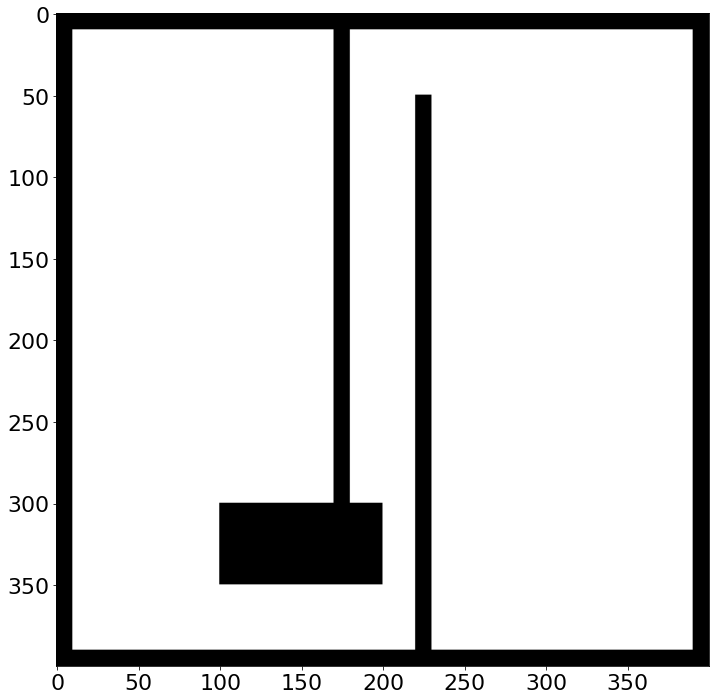

In [14]:
env.map[100:200,300:350] = 1
env.resetKDTree()
env.display()

To reconfigure the roadmap, we first recompute all nodes radii to extract modified (radius changed but still valid) and invalid (radius became invalid) nodes, before propagating theses modifications to the edges and reconnecting the graph components when necessary.

In [15]:
inv_nodes, mod_nodes = planner.recomputeNodesRadii(env)

In [16]:
planner.updateEdges(env, mod_nodes)

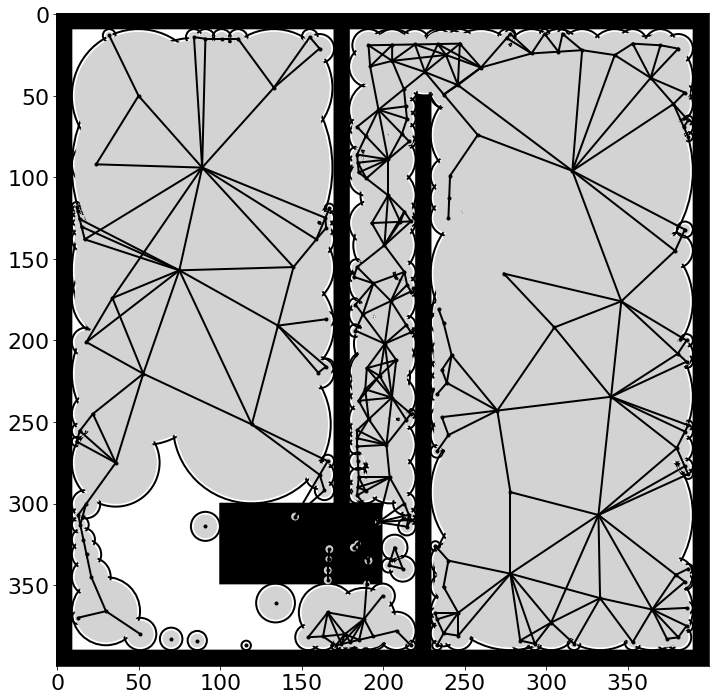

In [17]:
env.display()
displayBubbles(planner.graph, color='lightgrey')

In [18]:
MIN_COMPONENT_SIZE = 8
planner.updateOnMapUpdate(env, inv_nodes, mod_nodes, init_pos, MIN_COMPONENT_SIZE)

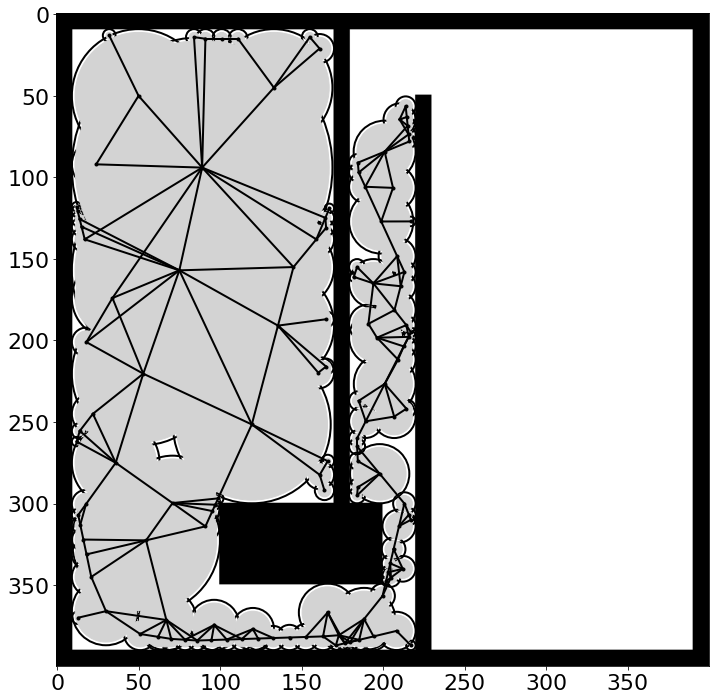

In [19]:
env.display()
displayBubbles(planner.graph, color='lightgrey')